# Gesture Heat Map Scatterplot

**Author:** Sharice Clough  
**Date:** 10 April, 2024

## Attribution

The gesture scatterplot code was adapted from **Börstell, C. (2023).** *Extracting sign language articulation from videos with MediaPipe.* In The 24th Nordic Conference on Computational Linguistics (NoDaLiDa).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
from scipy.stats import gaussian_kde
import numpy as np
import glob


In [2]:
# Get a list of all csv files in the processed data directory
import os
processed_dir = "../data/processed"  # Relative path from notebooks folder
files = glob.glob(os.path.join(processed_dir, '*.csv'))

print(f"Looking in: {processed_dir}")
print(f"Found files: {files}")

Looking in: ../data/processed
Found files: ['../data/processed/Life-Cycles_short_body.csv', '../data/processed/A-Dish-Best-Served-Cold_short_body.csv', '../data/processed/Roar_short_body.csv', '../data/processed/Missing-Pieces_short_body.csv']


In [3]:
# Initialize an empty list to store rescaled data frames
rescaled_data_list = []

# Rescale the motion tracking data
for file in files:
    # Read in each data file
    mt = pd.read_csv(file)
    mt['file_name'] = os.path.basename(file)
    
    # Calculate body width
    width = mt["X_LEFT_SHOULDER"].mean() - mt["X_RIGHT_SHOULDER"].mean()
    # Calculate x-coordinate for the origin
    x_origo = mt["X_RIGHT_SHOULDER"].mean() + (mt["X_LEFT_SHOULDER"].mean() - mt["X_RIGHT_SHOULDER"].mean()) / 2
    # Calculate y-coordinate for the origin (mid-shoulder)
    y_origo = mt[["Y_LEFT_SHOULDER", "Y_RIGHT_SHOULDER"]].mean().mean()
    # Calculate body height as distance from mid-shoulder to mid-hip
    y_mid_hip = mt[["Y_LEFT_HIP", "Y_RIGHT_HIP"]].mean().mean()
    height = abs(y_origo - y_mid_hip)
    # Define scaling factors for x and y
    x_factor = 1 / width
    y_factor = 0.6 / height
    
    mt_rescaled = mt.copy()
    # Apply transformations to x-coordinates
    mt_rescaled["X_NOSE"] = (mt["X_NOSE"] - x_origo) * x_factor
    mt_rescaled["X_LEFT_SHOULDER"] = (mt["X_LEFT_SHOULDER"] - x_origo) * x_factor
    mt_rescaled["X_RIGHT_SHOULDER"] = (mt["X_RIGHT_SHOULDER"] - x_origo) * x_factor
    mt_rescaled["X_LEFT_WRIST"] = (mt["X_LEFT_WRIST"] - x_origo) * x_factor
    mt_rescaled["X_RIGHT_WRIST"] = (mt["X_RIGHT_WRIST"] - x_origo) * x_factor

    # Apply transformations to y-coordinates
    mt_rescaled["Y_NOSE"] = (mt["Y_NOSE"] - y_origo) * y_factor
    mt_rescaled["Y_LEFT_SHOULDER"] = (mt["Y_LEFT_SHOULDER"] - y_origo) * y_factor
    mt_rescaled["Y_RIGHT_SHOULDER"] = (mt["Y_RIGHT_SHOULDER"] - y_origo) * y_factor
    mt_rescaled["Y_LEFT_WRIST"] = (mt["Y_LEFT_WRIST"] - y_origo) * y_factor
    mt_rescaled["Y_RIGHT_WRIST"] = (mt["Y_RIGHT_WRIST"] - y_origo) * y_factor
    mt_rescaled["file_name"] = file
    
    # Store the rescaled data frame in the list
    rescaled_data_list.append(mt_rescaled)

# Combine all rescaled data frames into a single data frame
all_rescaled_data = pd.concat(rescaled_data_list)

In [4]:
# Extract subject ID information from file name (First four characters of file name)
# You will have to customize this code for the format of your own file names
#all_rescaled_data["SubjectID"] = all_rescaled_data["file_name"].str[:4]
#all_rescaled_data["SubjectID"] = pd.Categorical(all_rescaled_data["SubjectID"])

In [5]:
# Reshape data from wide to long format
mt_rescaled_long = all_rescaled_data.melt(
    id_vars=["file_name", "time"],
    value_vars=["X_LEFT_WRIST", "Y_LEFT_WRIST", "X_RIGHT_WRIST", "Y_RIGHT_WRIST"],
    var_name="keypoint",
    value_name="coordinate"
)
mt_rescaled_long["hand"] = mt_rescaled_long["keypoint"].apply(lambda x: "LEFT" if "LEFT" in x else "RIGHT")
mt_rescaled_long["axis"] = mt_rescaled_long["keypoint"].apply(lambda x: "x_axis" if x.startswith("X") else "y_axis")
mt_rescaled_long.drop(columns=["keypoint"], inplace=True)

In [6]:
# Reshape data from long to wide format
both_hands = mt_rescaled_long.pivot(
    index=["file_name", "time", "hand"],
    columns="axis",
    values="coordinate"
).reset_index()

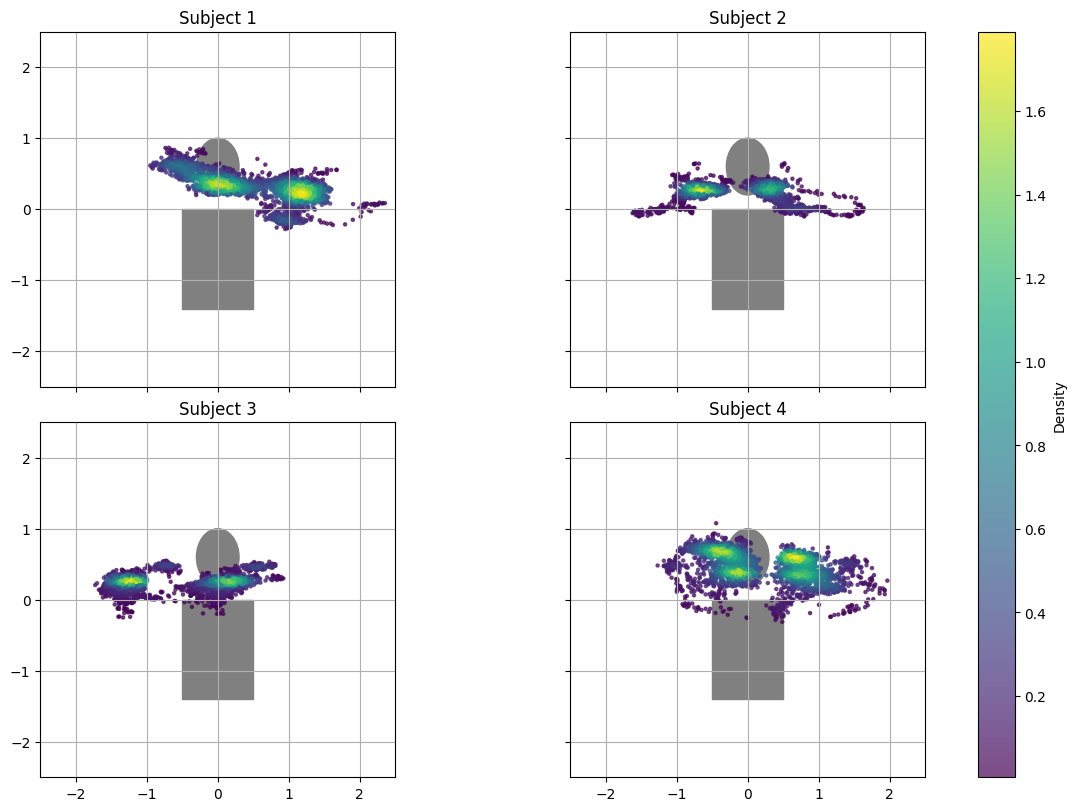

In [7]:
# Get unique SubjectID values
subject_ids = both_hands["file_name"].unique()

# Calculate grid dimensions
n_cols = 2  # Default number of columns -- Because I had four videos, I made this two, but change depending on the number of columns you want in the plot
n_rows = int(np.ceil(len(subject_ids) / n_cols))

# Create the plot
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows), constrained_layout=True, sharex=True, sharey=True)

# Plot each SubjectID separately
for i, subject_id in enumerate(subject_ids):
    row_idx = i // n_cols
    col_idx = i % n_cols
    ax = axes[row_idx, col_idx] if n_rows > 1 else axes[col_idx]
    data = both_hands[both_hands["file_name"] == subject_id]
    
    # Kernel density estimation
    kde = gaussian_kde(data[["x_axis", "y_axis"]].T)
    density = kde(data[["x_axis", "y_axis"]].T)
    
    # Plot ellipses
    ellipse = Ellipse((0, 0.6), 3/5, 4/5, angle=0, color="0.5", fill=True)
    ax.add_patch(ellipse)

    # Plot rectangle
    rectangle = Rectangle((-0.5, -1.4), 1, 1.4, color="0.5", fill=True)
    ax.add_patch(rectangle)

    # Plot point density with color mapping
    sc = ax.scatter(data["x_axis"], data["y_axis"], c=density, cmap='viridis', s=5, alpha=0.7)

    # Customize plot
    ax.set_title(f"SubjectID: {subject_id}")
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2.5, 2.5)
    ax.set_aspect('equal')  # Ensure equal aspect ratio
    ax.grid(True)

# Add colorbar
cbar = fig.colorbar(sc, ax=axes.ravel().tolist(), label='Density')

# Create output directory if it doesn't exist
output_dir = "../results/figures"
os.makedirs(output_dir, exist_ok=True)

# Save the plot
plt.savefig(os.path.join(output_dir, "heatmap_plot_grid.png"), dpi=300, bbox_inches='tight')
plt.show()
